In [2]:
import itertools
import yaml
from yaml.loader import SafeLoader
import mlflow
import mlflow.pyfunc
import joblib
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sdv.evaluation.single_table import run_diagnostic
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import evaluate_quality
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

os.chdir('/home/onyxia/work/synthetic-data-sdc/')
os.environ["MLFLOW_TRACKING_URI"] = "https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/" 

In [3]:
variables = ['sex','age','agegr','placesize','edu','socprof','marital','ls','depress','trust','trustfam','trustneigh','sport','nofriend','smoke','alcabuse','alcsol','wkabint','englang','height','weight','bmi']

In [4]:
original = pd.read_csv('SDV/df_original.csv', names = variables)

In [5]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(original)

In [30]:
with open("SDV/config_tvae_2.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

class TVAEWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        self.model = joblib.load(context.artifacts["model_path"])

    def predict(self, context, model_input):
        return self.model.sample(len(model_input))

remote_server_uri = os.environ["MLFLOW_TRACKING_URI"]
experiment_name = 'Default'
run_name = 'tvae_sd2011_' + str(config['compress_dims'][0]) + '_' + str(config['decompress_dims'][0]) + 'b' + str(config['batch_size']) + '_e' + str(config['epochs']) + '_gpu'

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):
    for param_key, param_value in config.items():
        if param_key != 'mlflow':
            mlflow.log_param(param_key, param_value)
    mlflow.log_param('run_name', run_name)

    #Entraînement
    start_time = time.time()
    tvae = TVAESynthesizer(metadata,
                           verbose=True,
                           compress_dims=config['compress_dims'],
                           decompress_dims=config['decompress_dims'],
                           batch_size=config['batch_size'],
                           epochs = config['epochs'])
    tvae.fit(original)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    mlflow.log_metric("elapsed_time", elapsed_time)
    print(f"Temps pris entraîner le modèle : {elapsed_time} secondes")
    
    params_tvae = tvae.get_parameters()
   

    # Log des paramètres du modèle
    for param_key, param_value in params_tvae.items():
        with mlflow.start_run(nested=True):
            mlflow.log_param(param_key, param_value)

    loss_by_epoch = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean().tolist()
    for epoch, loss in enumerate(loss_by_epoch):
        mlflow.log_metric("loss", loss, step=epoch+1)

    model_path = run_name + ".pkl"
    joblib.dump(tvae, model_path)
    mlflow.pyfunc.log_model(
        artifact_path="tvae_model",
        python_model=TVAEWrapper(),
        artifacts={"model_path": model_path},
    )
    mlflow.log_artifact("SDV/config_tvae_2.yml", artifact_path = "config_model")
    
mlflow.end_run()

/opt/conda/lib/python3.12/site-packages/sdv/single_table/base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: 19.717: 100%|██████████| 1000/1000 [09:09<00:00,  1.82it/s]
2024/08/29 10:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run unleashed-asp-616 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/c57bedcc6c864f88b57ff22eeef8b5b1.
2024/08/29 10:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.


Temps pris entraîner le modèle : 560.7001185417175 secondes


2024/08/29 10:27:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-skink-968 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/eebd3d52854e40f3b1d1d34bf5b152ea.
2024/08/29 10:27:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/29 10:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-quail-541 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/8bad4618e3b6467eaac33687d26c9d7b.
2024/08/29 10:27:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/29 10:27:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run dazzling-dove-392 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/58e951e12dc94a35b11247b1b67186fb.
20

In [7]:
tvae.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'embedding_dim': 128,
 'compress_dims': [256, 256, 256, 256],
 'decompress_dims': [256, 256, 256, 256],
 'l2scale': 1e-05,
 'batch_size': 100,
 'verbose': True,
 'epochs': 500,
 'loss_factor': 2,
 'cuda': True}

In [55]:
loss_by_epoch_retenu = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean()
nb_epochs = config['epochs']

Text(0.5, 1.0, "Loss d'un modèle TVAE sur SD2011")

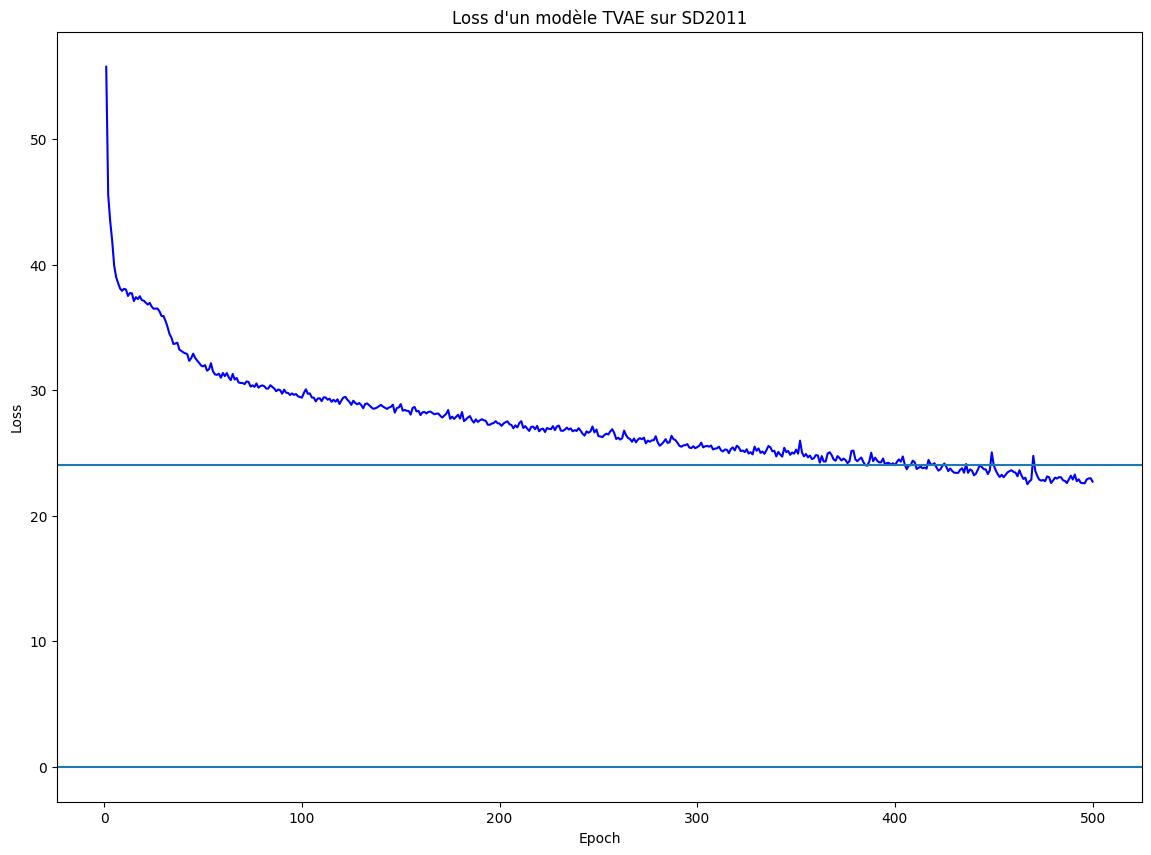

In [56]:
steps = range(1, nb_epochs+1)

plt.figure(figsize=(14, 10))

plt.plot(steps, loss_by_epoch_retenu, color='blue')
plt.axhline(0)
plt.axhline(24)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss d'un modèle TVAE sur SD2011")
#plt.legend()S

In [61]:
pd_loss = loss_by_epoch_retenu.to_frame()
new = [0,]
for i in range(499):
    new.append(pd_loss['Loss'][i])
pd_loss = pd_loss.assign(Loss_decale = new)
pd_loss = pd_loss.assign(Loss_diff = (pd_loss['Loss']-pd_loss['Loss_decale']))
pd_loss.head()

,Loss,Loss_decale,Loss_diff
Epoch,,,
0,55.759591,0.000000,55.759591
1,45.563561,55.759591,-10.196031
2,43.470922,45.563561,-2.092639
3,41.924866,43.470922,-1.546056
4,39.951701,41.924866,-1.973165


Text(0.5, 1.0, "Loss d'un modèle TVAE sur SD2011")

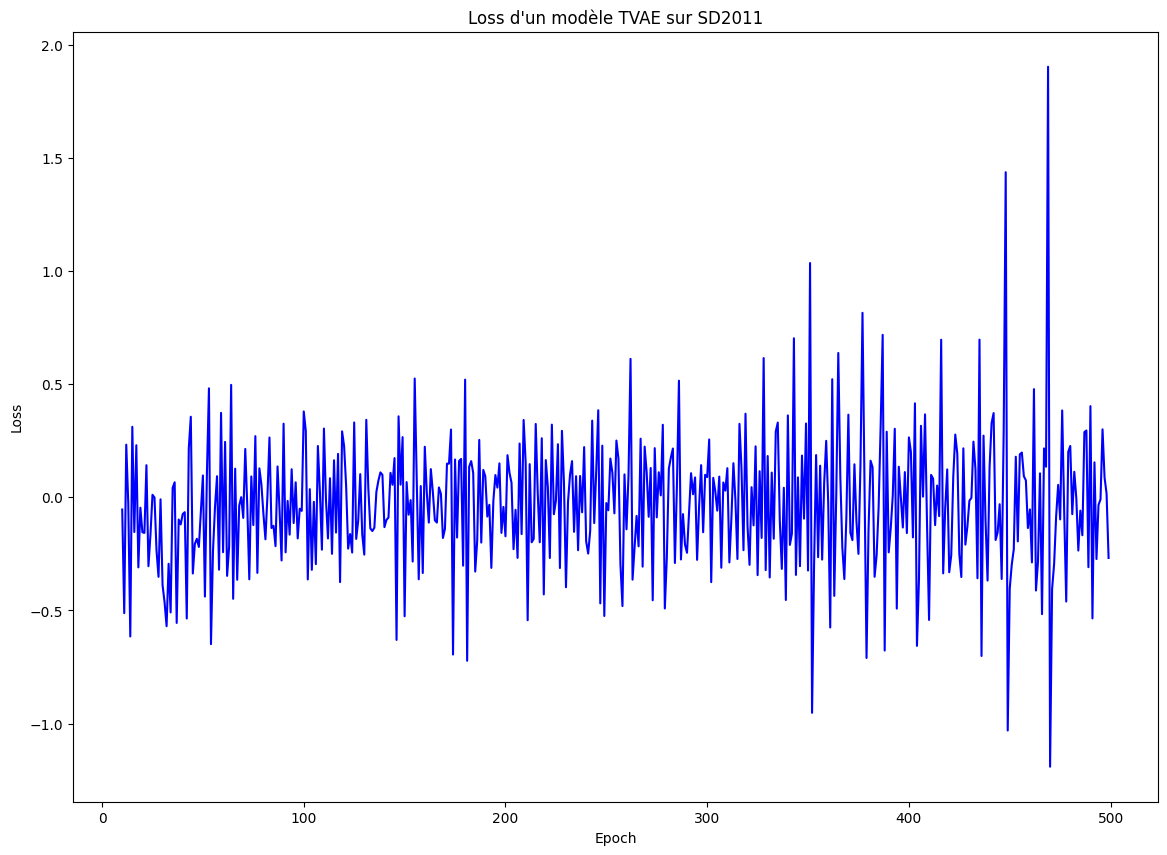

In [62]:
steps = range(10, nb_epochs)

plt.figure(figsize=(14, 10))

plt.plot(steps, pd_loss['Loss_diff'][10:], color='blue')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss d'un modèle TVAE sur SD2011")

## Variabilité du modèle

In [6]:
with open("SDV/config_tvae_3.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

In [ ]:
class TVAEWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        self.model = joblib.load(context.artifacts["model_path"])

    def predict(self, context, model_input):
        return self.model.sample(len(model_input))

remote_server_uri = os.environ["MLFLOW_TRACKING_URI"]
experiment_name = 'Default'

all_loss = {'epoch': [i for i in range(config['epochs'])]}

for i in range(100):
    if (i+1)%10 == 0:
        print(i+1)
    run_name = 'tvae_sd2011_' + str(config['compress_dims'][0]) + '_' + str(config['decompress_dims'][0]) + 'b' + str(config['batch_size']) + '_e' + str(config['epochs']) + 'iter' + str(i) + '_gpu'
    
    mlflow.set_tracking_uri(remote_server_uri)
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=run_name):
        for param_key, param_value in config.items():
            if param_key != 'mlflow':
                mlflow.log_param(param_key, param_value)
        mlflow.log_param('run_name', run_name)
    
        #Entraînement
        start_time = time.time()
        tvae = TVAESynthesizer(metadata,
                               verbose=False,
                               compress_dims=config['compress_dims'],
                               decompress_dims=config['decompress_dims'],
                               batch_size=config['batch_size'],
                               epochs = config['epochs'],
                               cuda = True)
        tvae.fit(original)
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        mlflow.log_metric("elapsed_time", elapsed_time)
        print(f"Temps pris entraîner le modèle : {elapsed_time} secondes")
        
        params_tvae = tvae.get_parameters()

        loss_by_epoch = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean().tolist()
        nom_iter = 'iter'+str(i)
        all_loss[nom_iter] = loss_by_epoch
       
        # Log des paramètres du modèle
        for param_key, param_value in params_tvae.items():
            with mlflow.start_run(nested=True):
                mlflow.log_param(param_key, param_value)    
        
        for epoch, loss in enumerate(loss_by_epoch):
            mlflow.log_metric("loss", loss, step=epoch+1)
    
        model_path = run_name + ".pkl"
        joblib.dump(tvae, model_path)
        mlflow.pyfunc.log_model(
            artifact_path="tvae_model",
            python_model=TVAEWrapper(),
            artifacts={"model_path": model_path},
        )
        mlflow.log_artifact("SDV/config_tvae_3.yml", artifact_path = "config_model")
        
    mlflow.end_run()

In [ ]:
import joblib

all_loss = {'epoch': [i for i in range(config['epochs'])]}
for i in range(100):
    model = 'tvae_sd2011_' + str(config['compress_dims'][0]) + '_' + str(config['decompress_dims'][0]) + 'b' + str(config['batch_size']) + '_e' + str(config['epochs']) + 'iter' + str(i) + '_gpu.pkl'
    tvae = joblib.load(model)
    loss_by_epoch = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean().tolist()
    nom_iter = 'iter'+str(i)
    all_loss[nom_iter] = loss_by_epoch


In [8]:
pd_all_loss = pd.DataFrame.from_dict(all_loss)
pd_all_loss.shape

(500, 101)

In [9]:
all_means = pd_all_loss.loc[:, pd_all_loss.columns != 'epoch'].mean(axis=1)
all_sds = pd_all_loss.loc[:, pd_all_loss.columns != 'epoch'].std(axis=1)
all_cvs = all_sds/all_means *100 
all_q05 = pd_all_loss.loc[:, pd_all_loss.columns != 'epoch'].quantile(q=0.05, axis=1)
all_q95 = pd_all_loss.loc[:, pd_all_loss.columns != 'epoch'].quantile(q=0.95, axis=1)

In [74]:
all_q05[499], all_q95[499]

(22.712045198805786, 27.0683393316066)

In [10]:
tvae_rapport = joblib.load('tvae_model_tvae_bs_100_comp_dims_[256, 256]_decomp_dims_[256, 256].pkl')
loss_by_epoch_rapport = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean().tolist()

/opt/conda/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator BayesianGaussianMixture from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be a

In [11]:
loss_by_10ep_rapport = []
for j in range(50):
    loss_by_10ep_rapport.append(pd.Series(loss_by_epoch_rapport[j*10:(j+1)*10]).mean())

In [12]:
pd_loss_by_10ep = pd.DataFrame({'loss_by_10ep': loss_by_10ep_rapport, 'loss_dec': [ loss_by_10ep_rapport[i-1] if i > 0 else 0 for i in range(50) ]}) 
pd_loss_by_10ep = pd_loss_by_10ep.assign(Loss_diff = (pd_loss_by_10ep['loss_by_10ep']-pd_loss_by_10ep['loss_dec']))

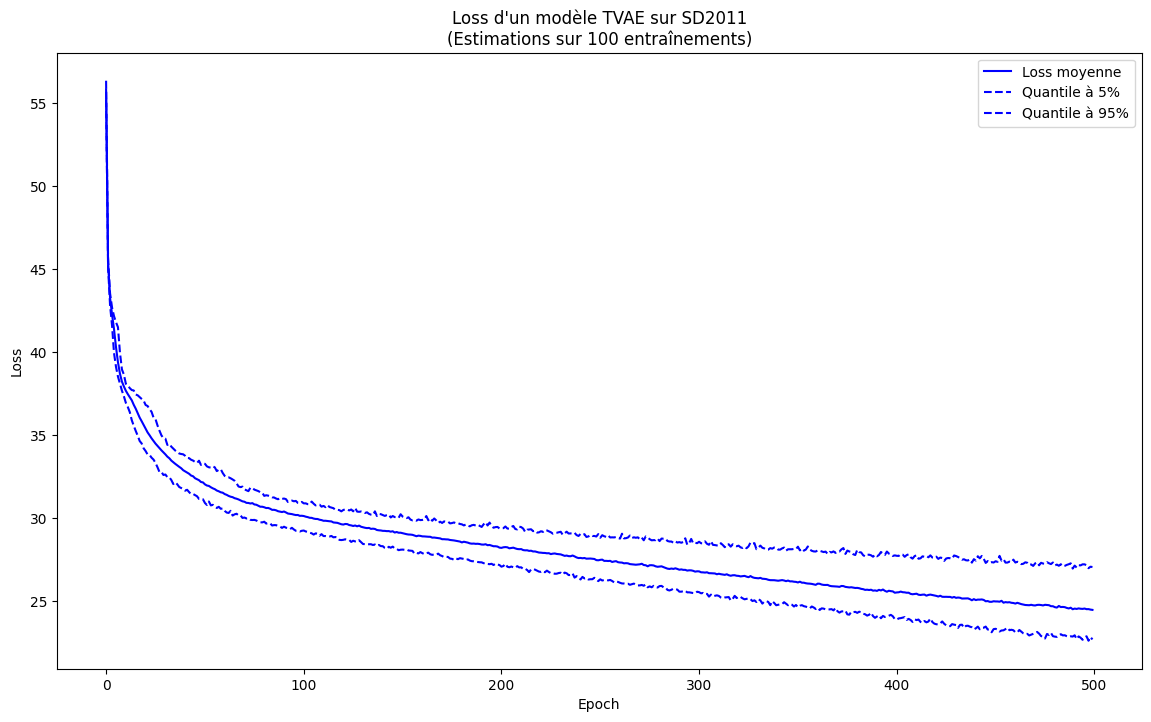

In [75]:
steps = range(500)

plt.figure(figsize=(14, 8))

plt.plot(steps, all_means, color='blue', label = "Loss moyenne")
#plt.plot(steps, loss_by_epoch_rapport, color='orange', label = "Loss du modèle retenu")
plt.plot(steps, all_q05, color='blue', linestyle = "dashed", label = "Quantile à 5%")
plt.plot(steps, all_q95, color='blue', linestyle = "dashed", label = "Quantile à 95%")
#plt.axhline(loss_by_epoch_rapport[499], color = 'orange', linestyle = "dotted", label = "Loss finale du modèle retenu")
#plt.axhline(0, color = 'black', linestyle = "dotted")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss d'un modèle TVAE sur SD2011\n(Estimations sur 100 entraînements)")
plt.legend()
plt.savefig("MC_LOSS_TVAE_SD2011.pdf", bbox_inches='tight')

In [77]:
pd_loss_by_10ep.iloc[1:]['Loss_diff']

1   -5.920513
2   -1.494585
3   -1.112242
4   -0.963948
5   -0.933282
6   -0.785179
7   -0.684791
8   -0.680850
9   -0.803582
Name: Loss_diff, dtype: float64

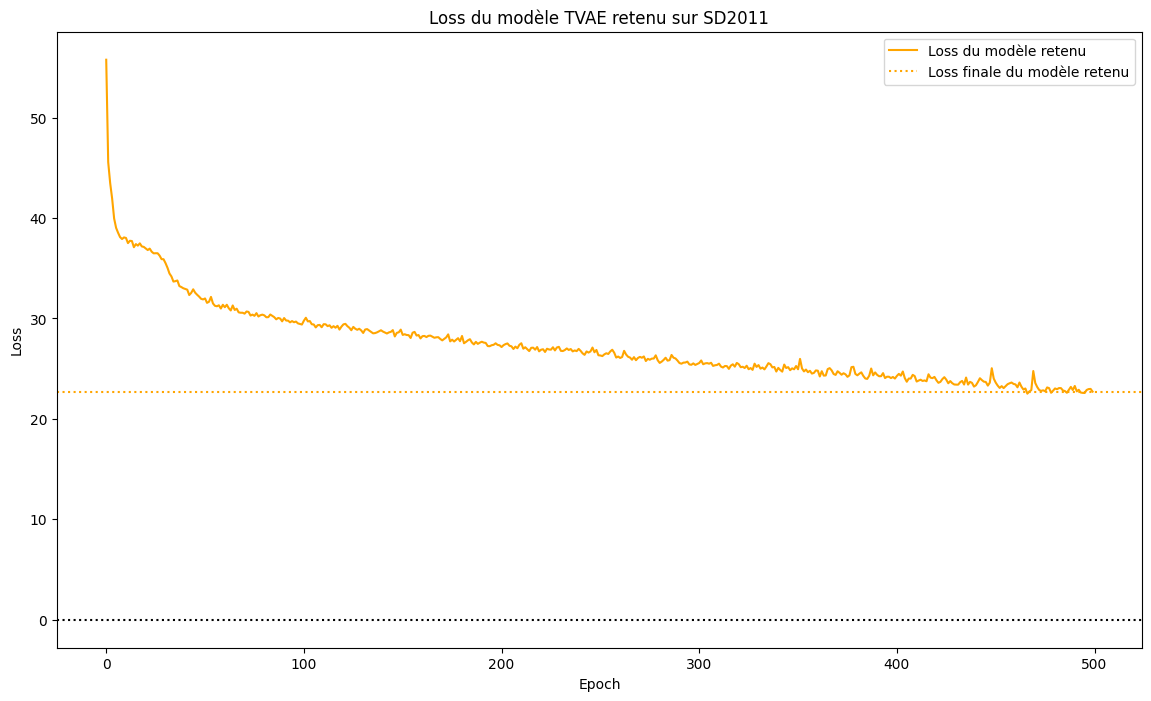

In [45]:
steps = range(500)

plt.figure(figsize=(14, 8))

plt.plot(steps, loss_by_epoch_rapport, color='orange', label = "Loss du modèle retenu")
plt.axhline(loss_by_epoch_rapport[499], color = 'orange', linestyle = "dotted", label = "Loss finale du modèle retenu")
#plt.axhline(0, color = 'black', linestyle = "dotted")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss du modèle TVAE retenu sur SD2011")
plt.legend()
plt.savefig("LOSS_TVAE_SD2011.pdf", bbox_inches='tight')

In [47]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

In [46]:
type(loss_by_epoch_rapport)

list

In [69]:
loss_moving_average = moving_average(np.array(pd_loss['Loss_diff'].tolist()[1:]), 10)
loss_moving_average.shape

(490,)

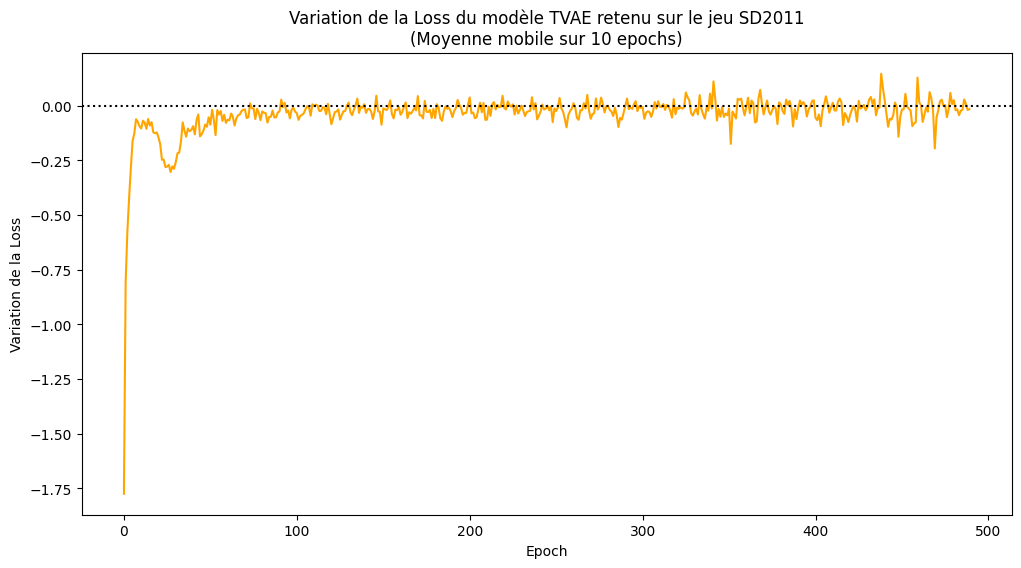

In [72]:
steps = range(0,490)

fig, ax = plt.subplots(figsize=(12, 6))

#plt.plot(steps, pd_loss_by_10ep.iloc[1:]['Loss_diff'], color='orange',label = "Modele retenu")
plt.plot(steps, loss_moving_average, color='orange',label = "Modele retenu")
#ax.set_xticks(range(0,51,10), labels = [i*10 for i in range(0,51,10)])
plt.axhline(0, color='black', linestyle="dotted")
plt.xlabel('Epoch')
plt.ylabel('Variation de la Loss')
plt.title("Variation de la Loss du modèle TVAE retenu sur le jeu SD2011\n(Moyenne mobile sur 10 epochs)")
plt.savefig("MOYMOB_LOSS_TVAE_SD2011.pdf", bbox_inches='tight')

## GRID SEARCH

In [26]:
with open("SDV/config_tvae_grid.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

class TVAEWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        self.model = joblib.load(context.artifacts["model_path"])

    def predict(self, context, model_input):
        return self.model.sample(len(model_input))


compress_dims_values = config['compress_dims']
decompress_dims_values = config['decompress_dims']
batch_size_values = config['batch_size']
epochs_values = config['epochs']

In [27]:
param_combinations = list(itertools.product(compress_dims_values, decompress_dims_values, batch_size_values, epochs_values))

In [28]:
param_combinations

[([128, 128, 128, 128], [128, 128, 128, 128], 50),
 ([128, 128, 128, 128], [128, 128, 128, 128], 100),
 ([128, 128, 128, 128], [128, 128, 128, 128], 250),
 ([128, 128, 128, 128], [256, 256, 256, 256], 50),
 ([128, 128, 128, 128], [256, 256, 256, 256], 100),
 ([128, 128, 128, 128], [256, 256, 256, 256], 250),
 ([128, 128, 128, 128], [1024, 1024, 1024, 1024], 50),
 ([128, 128, 128, 128], [1024, 1024, 1024, 1024], 100),
 ([128, 128, 128, 128], [1024, 1024, 1024, 1024], 250),
 ([256, 256, 256, 256], [128, 128, 128, 128], 50),
 ([256, 256, 256, 256], [128, 128, 128, 128], 100),
 ([256, 256, 256, 256], [128, 128, 128, 128], 250),
 ([256, 256, 256, 256], [256, 256, 256, 256], 50),
 ([256, 256, 256, 256], [256, 256, 256, 256], 100),
 ([256, 256, 256, 256], [256, 256, 256, 256], 250),
 ([256, 256, 256, 256], [1024, 1024, 1024, 1024], 50),
 ([256, 256, 256, 256], [1024, 1024, 1024, 1024], 100),
 ([256, 256, 256, 256], [1024, 1024, 1024, 1024], 250),
 ([1024, 1024, 1024, 1024], [128, 128, 128, 12

In [14]:
remote_server_uri = os.environ["MLFLOW_TRACKING_URI"]
experiment_name = 'Default'
run_name = 'tvae_sd2011_' + str(config['compress_dims'][0]) + '_' + str(config['decompress_dims'][0]) + 'b' + str(config['batch_size'][0]) + '_e' + str(config['epochs'][0]) + '_gpu'

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)

for param_set in param_combinations:
    compress_dims, decompress_dims, batch_size = param_set
    run_name = f"tvae_bs_{batch_size}_comp_dims_{compress_dims}_decomp_dims_{decompress_dims}"

    with mlflow.start_run(run_name=run_name):
        # Log des paramètres de configuration
        mlflow.log_param('compress_dims', compress_dims)
        mlflow.log_param('decompress_dims', decompress_dims)
        mlflow.log_param('batch_size', batch_size)
        
        # Entraînement
        start_time = time.time()
        tvae = TVAESynthesizer(metadata,
                           verbose=True,
                           compress_dims=compress_dims,
                           decompress_dims=decompress_dims,
                           batch_size=batch_size)
        tvae.fit(original)
        end_time = time.time()

        elapsed_time = end_time - start_time
        mlflow.log_metric("elapsed_time", elapsed_time)
        print(f"Temps pris pour entraîner le modèle avec 300 epochs: {elapsed_time} secondes")

        # Log des pertes du générateur et du discriminateur
        loss = tvae.get_loss_values()
        losses = loss['Loss'].tolist()
        for epoch, loss in enumerate(losses):
            mlflow.log_metric("loss", loss, step=epoch)

        # Sauvegarde du modèle
        model_path = f"tvae_model_{run_name}.pkl"
        joblib.dump(tvae, model_path)
        mlflow.pyfunc.log_model(
            artifact_path="tvae_model",
            python_model=TVAEWrapper(),
            artifacts={"model_path": model_path},
        )
    mlflow.end_run()

'tvae_sd2011_256_256_b100_e500_gpu'